# Investigate inflated component z-statistics in tedana

In [1]:
%matplotlib inline
import os.path as op

import numpy as np
import tedana.stats as tedstats
import statsmodels.api as sm
from scipy import stats
from scipy.special import ndtri

import pandas as pd
from nilearn.image import math_img
from nilearn.masking import apply_mask, unmask

import matplotlib.pyplot as plt
import seaborn as sns

/Users/tsalo/.local/lib/python3.6/site-packages/scikit_learn-0.21.2-py3.6-macosx-10.7-x86_64.egg/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def p_to_z(p, tail='two'):
    """Convert p-values to z-values.
    """
    eps = np.spacing(1)
    p = np.array(p)
    p[p < eps] = eps
    if tail == 'two':
        z = ndtri(1 - (p / 2))
        z = np.array(z)
    elif tail == 'one':
        z = ndtri(1 - p)
        z = np.array(z)
        z[z < 0] = 0
    else:
        raise ValueError('Argument "tail" must be one of ["one", "two"]')

    if z.shape == ():
        z = z[()]
    return z


def computefeats_sm(data, mmix):
    """
    Converts `data` to component space using `mmix`

    Parameters
    ----------
    data : (S x T) array_like
        Input data
    mmix : (T [x C]) array_like
        Mixing matrix for converting input data to component space, where `C`
        is components and `T` is the same as in `data`

    Returns
    -------
    data_Z : (S x C) :obj:`numpy.ndarray`
        Data in component space
    """
    # demean masked data
    data2 = data - np.mean(data, axis=1, keepdims=True)
    data2 = stats.zscore(data, axis=1)
    mmix2 = stats.zscore(mmix, axis=0)

    data_Z = np.empty((data.shape[0], mmix.shape[1]))
    for i_voxel in range(data.shape[0]):
        model = sm.OLS(data2[i_voxel, :], mmix2)
        results = model.fit()
        zvalues = p_to_z(results.pvalues, tail='two') * np.sign(results.params)
        data_Z[i_voxel, :] = zvalues
    return data_Z

In [19]:
in_dir = '/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/e5-checkerboard-test'

adaptive_mask = op.join(in_dir, 'adaptive_mask.nii.gz')
mask = math_img('img == 5', img=adaptive_mask)

optcom = op.join(in_dir, 'ts_OC.nii.gz')
optcom = apply_mask(optcom, mask).T
# Reduce for speed
#optcom = optcom[1000:2000, :]

# Let's start with PCA

In [22]:
mixing = op.join(in_dir, 'ica_mixing.tsv')
mixing = pd.read_csv(mixing, sep='\t').values

betas = op.join(in_dir, 'ica_components.nii.gz')
betas = apply_mask(betas, mask).T
print(np.where(betas == np.max(betas)))
print(np.max(betas))

(array([12092]), array([53]))
34.39577769510263


In [25]:
mixing_z = stats.zscore(mixing, axis=0)
model = sm.OLS(optcom[12092, :], mixing[:, :-1])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):            -78.997
Method:                 Least Squares   F-statistic:                          4.478e-07
Date:                Mon, 02 Dec 2019   Prob (F-statistic):                        1.00
Time:                        10:55:49   Log-Likelihood:                         -1688.7
No. Observations:                 160   AIC:                                      3693.
Df Residuals:                       2   BIC:                                      4179.
Df Model:                         158                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5420   1.34e+04  -4.05e-05      1.000   -5.76e+04    5.76e+04
x2             1.8812   1.18e+04      0.000      1.000   -5.06e+04    5.06e+04
x3            -2.0726   1.19e+04     -0.000      1.000   -5.11e+04    5.11e+04
x4             1.4310   1.36e+04      0.000      1.000   -5.83e+04    5.83e+04
x5             1.3577   1.05e+04      0.000      1.000   -4.52e+04    4.52e+04
x6             3.8046   1.17e+04      0.000      1.000   -5.03e+04    5.03e+04
x7            -2.9295   1.06e+04     -0.000      1.000   -4.58e+04    4.58e+04
x8             9.9962   1.36e+04      0.001      0.999   -5.83e+04    5.83e+04
x9             0.1117   1.06e+04   1.05e-05      1.000   -4.57e+04    4.57e+04
x10           -2.9505   9939.311     -0.000      1.000   -4.28e+04    4.28e+04
x11            0.0031    1.1e+04   2.83e-07      1.000   -4.72e+04    4.72e+04
x12            1.4862   1.07e+04      0.000      1.000    -4.6e+04     4.6e+04
x13           -0.4733   1.04e+04  -4.55e-05      1.000   -4.47e+04    4.47e+04
x14            1.6238   1.07e+04      0.000      1.000   -4.61e+04    4.61e+04
x15            1.8379   9433.272      0.000      1.000   -4.06e+04    4.06e+04
x16           -3.3380   1.03e+04     -0.000      1.000   -4.44e+04    4.44e+04
x17            0.1639   9048.697   1.81e-05      1.000   -3.89e+04    3.89e+04
x18            0.9175   8984.390      0.000      1.000   -3.87e+04    3.87e+04
x19            0.5843   1.05e+04   5.56e-05      1.000   -4.52e+04    4.52e+04
x20           -1.0944   1.02e+04     -0.000      1.000   -4.37e+04    4.37e+04
x21           -1.6730   1.05e+04     -0.000      1.000   -4.54e+04    4.54e+04
x22            0.0223   1.11e+04   2.01e-06      1.000   -4.78e+04    4.78e+04
x23           -0.2333   1.26e+04  -1.85e-05      1.000   -5.41e+04    5.41e+04
x24            2.5306   1.02e+04      0.000      1.000    -4.4e+04     4.4e+04
x25            0.2533   9407.355   2.69e-05      1.000   -4.05e+04    4.05e+04
x26           -0.0673   1.03e+04  -6.53e-06      1.000   -4.43e+04    4.43e+04
x27            6.1446   9329.460      0.001      1.000   -4.01e+04    4.01e+04
x28            0.7617   1.14e+04   6.67e-05      1.000   -4.92e+04    4.92e+04
x29            0.8707   9395.816   9.27e-05      1.000   -4.04e+04    4.04e+04
x30            0.1276   1.08e+04   1.18e-05      1.000   -4.63e+04    4.63e+04
x31            5.4611   1.29e+04      0.000      1.000   -5.56e+04    5.56e+04
x32            1.2560   9570.443      0.000      1.000   -4.12e+04    4.12e+04
x33           -0.5015   9205.312  -5.45e-05      1.000   -3.96e+04    3.96e+04
x34           10.3272   1.66e+04      0.001      1.000   -7.13e+04    7.14e+04
x35           -0.5904   1.05e+04   -5.6e-05      1.000   -4.5

In [26]:
model = sm.GLM(optcom[12092, :], mixing[:, :-1])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  160
Model:                            GLM   Df Residuals:                        2
Model Family:                Gaussian   Df Model:                          157
Link Function:               identity   Scale:                      6.8905e+09
Method:                          IRLS   Log-Likelihood:                -1688.7
Date:                Mon, 02 Dec 2019   Deviance:                   1.3781e+10
Time:                        10:55:59   Pearson chi2:                 1.38e+10
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5420   1.34e+04  -4.05e-05      1.000   -2.62e+04    2.62e+04
x2             1.8812   1.18e+04      0.000      1.000    -2.3e+04     2.3e+04
x3            -2.0726   1.19e+04     -0.000      1.000   -2.33e+04    2.33e+04
x4             1.4310   1.36e+04      0.000      1.000   -2.66e+04    2.66e+04
x5             1.3577   1.05e+04      0.000      1.000   -2.06e+04    2.06e+04
x6             3.8046   1.17e+04      0.000      1.000   -2.29e+04    2.29e+04
x7            -2.9295   1.06e+04     -0.000      1.000   -2.09e+04    2.08e+04
x8             9.9962   1.36e+04      0.001      0.999   -2.66e+04    2.66e+04
x9             0.1117   1.06e+04   1.05e-05      1.000   -2.08e+04    2.08e+04
x10           -2.9505   9939.311     -0.000      1.000   -1.95e+04    1.95e+04
x11            0.0031    1.1e+04   2.83e-07      1.000   -2.15e+04    2.15e+04
x12            1.4862   1.07e+04      0.000      1.000   -2.09e+04     2.1e+04
x13           -0.4733   1.04e+04  -4.55e-05      1.000   -2.04e+04    2.04e+04
x14            1.6238   1.07e+04      0.000      1.000    -2.1e+04     2.1e+04
x15            1.8379   9433.272      0.000      1.000   -1.85e+04    1.85e+04
x16           -3.3380   1.03e+04     -0.000      1.000   -2.02e+04    2.02e+04
x17            0.1639   9048.697   1.81e-05      1.000   -1.77e+04    1.77e+04
x18            0.9175   8984.390      0.000      1.000   -1.76e+04    1.76e+04
x19            0.5843   1.05e+04   5.56e-05      1.000   -2.06e+04    2.06e+04
x20           -1.0944   1.02e+04     -0.000      1.000   -1.99e+04    1.99e+04
x21           -1.6730   1.05e+04     -0.000      1.000   -2.07e+04    2.07e+04
x22            0.0223   1.11e+04   2.01e-06      1.000   -2.18e+04    2.18e+04
x23           -0.2333   1.26e+04  -1.85e-05      1.000   -2.47e+04    2.47e+04
x24            2.5306   1.02e+04      0.000      1.000      -2e+04    2.01e+04
x25            0.2533   9407.355   2.69e-05      1.000   -1.84e+04    1.84e+04
x26           -0.0673   1.03e+04  -6.53e-06      1.000   -2.02e+04    2.02e+04
x27            6.1446   9329.460      0.001      0.999   -1.83e+04    1.83e+04
x28            0.7617   1.14e+04   6.67e-05      1.000   -2.24e+04    2.24e+04
x29            0.8707   9395.816   9.27e-05      1.000   -1.84e+04    1.84e+04
x30            0.1276   1.08e+04   1.18e-05      1.000   -2.11e+04    2.11e+04
x31            5.4611   1.29e+04      0.000      1.000   -2.53e+04    2.53e+04
x32            1.2560   9570.443      0.000      1.000   -1.88e+04    1.88e+04
x33           -0.5015   9205.312  -5.45e-05      1.000    -1.8e+04     1.8e+04
x34           10.3272   1.66e+04      0.001      1.000   -3.25e+04    3.25e+04
x35           -0.5904   1.05e+04   -5.6e-05      1.000   -2.07e+04    2.07e+04
x36           -2.0817   9051.976     -0.000      1.000   -1.77e+04    1.77e+04
x3

In [5]:
%%time
dofs = []
things_to_run = list(range(0, mixing.shape[1] - 2, 5))
feats1 = np.empty((optcom.shape[0], len(things_to_run)))
feats2 = np.empty((optcom.shape[0], len(things_to_run)))

for i, n_comps in enumerate(things_to_run):
    temp_mixing = mixing[:, :mixing.shape[1] - n_comps]
    dof = mixing.shape[0] - (mixing.shape[1] - n_comps)
    dofs.append(dof)
    temp_feats1 = tedstats.computefeats2(optcom, temp_mixing)
    temp_feats1 = stats.zscore(temp_feats1, axis=0)  # what we do for Z_maps

    temp_feats2 = computefeats_sm(optcom, temp_mixing)
    feats1[:, i] = temp_feats1[:, 0]
    feats2[:, i] = temp_feats2[:, 0]

CPU times: user 4min 31s, sys: 28 s, total: 4min 59s
Wall time: 2min 56s


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


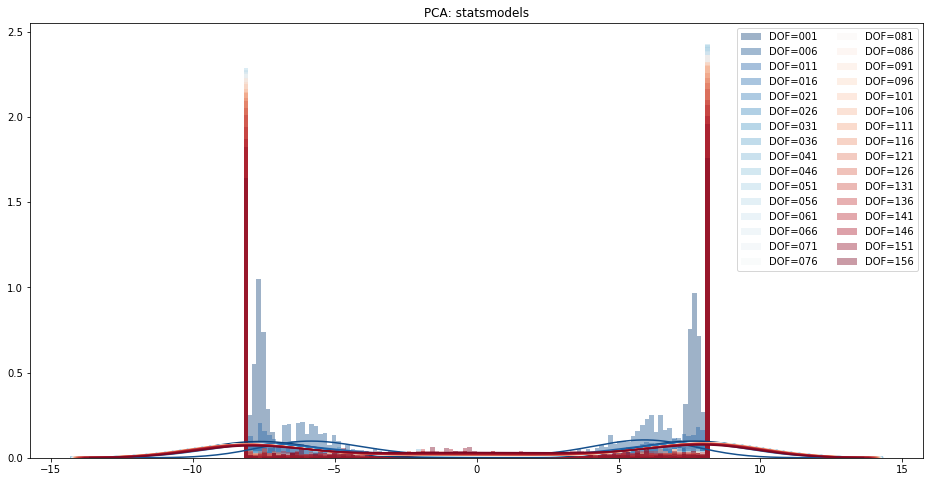

In [6]:
sns.set_palette(sns.color_palette("RdBu_r", feats2.shape[1]))
fig, ax = plt.subplots(figsize=(16, 8))
for i in range(feats2.shape[1]):
    sns.distplot(feats2[:, i], label='DOF={0:03d}'.format(dofs[i]), ax=ax, bins=100, norm_hist=True)
ax.legend(ncol=2)
ax.set_title('PCA: statsmodels')
fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


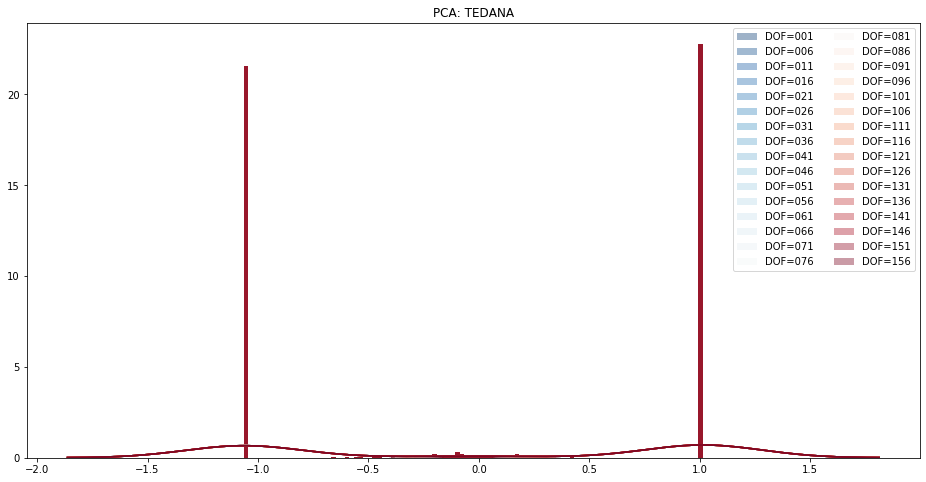

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
for i in range(feats1.shape[1]):
    sns.distplot(feats1[:, i], label='DOF={0:03d}'.format(dofs[i]), ax=ax, bins=100, norm_hist=True)
ax.legend(ncol=2)
ax.set_title('PCA: TEDANA')
fig.show()

# Now ICA

In [8]:
mixing = op.join(in_dir, 'ica_mixing.tsv')
mixing = pd.read_csv(mixing, sep='\t').values

In [9]:
%%time
dofs = []
things_to_run = list(range(0, mixing.shape[1] - 2, 5))
feats1 = np.empty((optcom.shape[0], len(things_to_run)))
feats2 = np.empty((optcom.shape[0], len(things_to_run)))

for i, n_comps in enumerate(things_to_run):
    temp_mixing = mixing[:, :mixing.shape[1] - n_comps]
    dof = mixing.shape[0] - (mixing.shape[1] - n_comps)
    dofs.append(dof)
    temp_feats1 = tedstats.computefeats2(optcom, temp_mixing)
    temp_feats1 = stats.zscore(temp_feats1, axis=0)  # what we do for Z_maps

    temp_feats2 = computefeats_sm(optcom, temp_mixing)
    feats1[:, i] = temp_feats1[:, 0]
    feats2[:, i] = temp_feats2[:, 0]

CPU times: user 5min 29s, sys: 30.2 s, total: 5min 59s
Wall time: 3min 25s


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


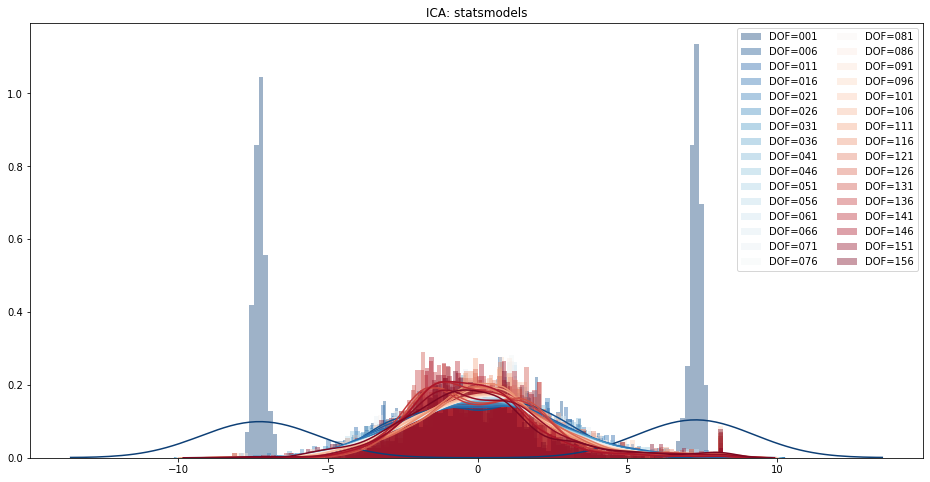

In [10]:
sns.set_palette(sns.color_palette("RdBu_r", feats2.shape[1]))
fig, ax = plt.subplots(figsize=(16, 8))
for i in range(feats2.shape[1]):
    sns.distplot(feats2[:, i], label='DOF={0:03d}'.format(dofs[i]), ax=ax, bins=100, norm_hist=True)
ax.legend(ncol=2)
ax.set_title('ICA: statsmodels')
fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


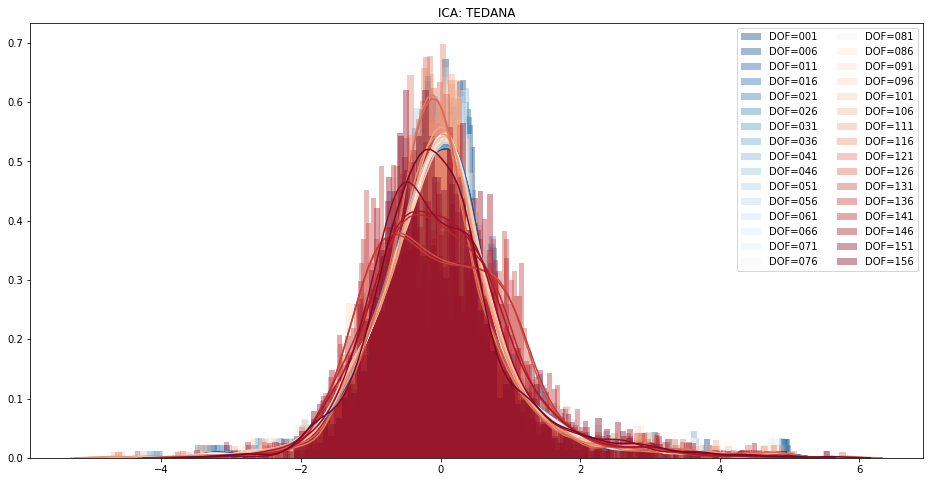

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
for i in range(feats1.shape[1]):
    sns.distplot(feats1[:, i], label='DOF={0:03d}'.format(dofs[i]), ax=ax, bins=100, norm_hist=True)
ax.legend(ncol=2)
ax.set_title('ICA: TEDANA')
fig.show()